In [ ]:
!pip install transformers datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 16.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system 

In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer
from datasets import load_dataset
import numpy as np
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from google.colab import drive
import time

from IPython.display import display
import ipywidgets as widgets

# Part 1 : Extract Embeddings and plot

## Loading Model & Tokenizer

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
dataset = load_dataset("cfilt/iitb-english-hindi")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 1659083
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 520
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 2507
    })
})


## Splitting Dataset into Training, Validation and Test

In [ ]:
train_dataset = dataset['train']
valid_dataset = dataset['validation']
test_dataset = dataset['test']

In [ ]:
train_en_length = [len(x['en'].split()) for x in train_dataset['translation']]
train_hi_length = [len(x['hi'].split()) for x in train_dataset['translation']]

## Finding the distribution of sentence length for the dataset

<ipython-input-7-35e4fd24910b>:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
<ipython-input-7-35e4fd24910b>:16: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


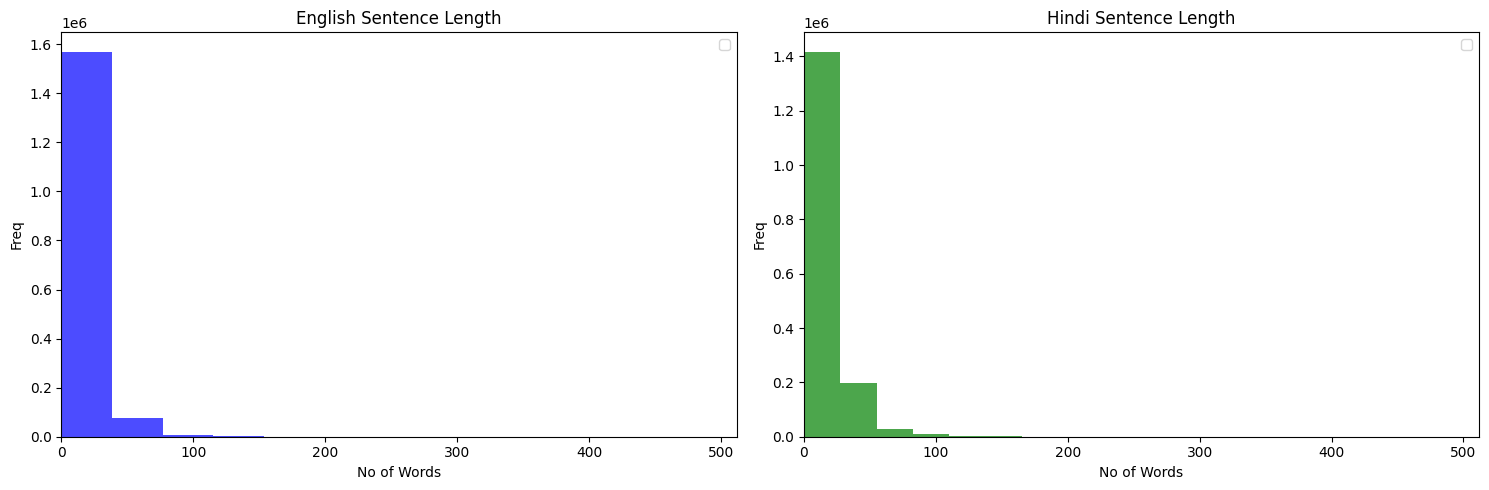

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.hist(train_en_length, bins=50, color='blue', alpha=0.7)
ax1.set_title('English Sentence Length')
ax1.set_xlabel('No of Words')
ax1.set_ylabel('Freq')
ax1.set_xlim(0, 512)
ax1.legend()


ax2.hist(train_hi_length, bins=50, color='green', alpha=0.7)
ax2.set_title('Hindi Sentence Length')
ax2.set_xlabel('No of Words')
ax2.set_ylabel('Freq')
ax2.set_xlim(0, 512)
ax2.legend()

plt.tight_layout()
plt.show()


In [ ]:
def separate_sentences(dataset):
    english_sentences = []
    hindi_sentences = []

    for translation in dataset['translation']:
        english_sentences.append(translation['en'])
        hindi_sentences.append(translation['hi'])

    return english_sentences, hindi_sentences

english_sentences, hindi_sentences = separate_sentences(test_dataset)

## Getting sentence embeddings for English & Hindi Sentences for Test Dataset

In [ ]:
def get_sentence_embeddings(model, tokenizer, sentences, device='cuda'):
    model.to(device)
    embeddings = []
    model.eval()

    with torch.no_grad():
        for sentence in tqdm(sentences):
            inputs = tokenizer(sentence, padding=True, truncation=True, max_length=512, return_tensors='pt').to(device)
            outputs = model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :]
            embeddings.append(cls_embedding.cpu().numpy()[0])

    return np.array(embeddings)

## Finding Mean Similarity, Accuracy and Mean Reciprocal Rank

In [ ]:
def compute_alignment_metrics(en_embeddings, hi_embeddings):

    similarities = np.array([
        cosine_similarity(en_emb.reshape(1, -1), hi_emb.reshape(1, -1))[0][0]
        for en_emb, hi_emb in zip(en_embeddings, hi_embeddings)
    ])

    mean_similarity = np.mean(similarities)

    n = len(en_embeddings)
    similarity_matrix = cosine_similarity(en_embeddings, hi_embeddings)
    correct_retrievals = sum(np.argmax(similarity_matrix, axis=1) == np.arange(n))
    retrieval_accuracy = correct_retrievals / n

    ranks = []
    for i in range(n):
        sorted_indices = np.argsort(-similarity_matrix[i])
        rank = np.where(sorted_indices == i)[0][0] + 1
        ranks.append(1/rank)
    mrr = np.mean(ranks)

    return {
        'mean_similarity': mean_similarity,
        'retrieval_accuracy': retrieval_accuracy,
        'similarities': similarities,
        'mean_reciprocal_rank': mrr
    }

In [ ]:
n_sentences = 10000
english_sentences = english_sentences[:n_sentences]
hindi_sentences = hindi_sentences[:n_sentences]
en_embeddings = get_sentence_embeddings(model, tokenizer, english_sentences, device)
hi_embeddings = get_sentence_embeddings(model, tokenizer, hindi_sentences, device)

100%|██████████| 2507/2507 [00:34<00:00, 71.75it/s]


In [ ]:
metrics = compute_alignment_metrics(en_embeddings, hi_embeddings)

print("Baseline Analysis Results:")

print(f"\nMean Cosine Similarity: {metrics['mean_similarity']:.4f}")
print(f"Retrieval Accuracy: {metrics['retrieval_accuracy']:.4f}")
print(f"Mean Reciprocal Rank: {metrics['mean_reciprocal_rank']:.4f}")

Baseline Analysis Results:

Mean Cosine Similarity: 0.7160
Retrieval Accuracy: 0.2585
Mean Reciprocal Rank: 0.3414


In [ ]:
np.save('en_sentences.npy', np.array(english_sentences))
np.save('hi_sentences.npy', np.array(hindi_sentences))
np.save('en_embeddings.npy', en_embeddings)
np.save('hi_embeddings.npy', hi_embeddings)
np.save('similarities.npy', metrics['similarities'])

## Combined English & Hindi Embeddings into a tsv file and adding metadata also

In [ ]:
en_embeddings = np.load("/content/en_embeddings.npy")
english_sentences = np.load("/content/en_sentences.npy")
hi_embeddings = np.load("/content/hi_embeddings.npy")
hindi_sentences = np.load("/content/hi_sentences.npy")

In [ ]:
len(hi_embeddings), len(hindi_sentences)

(2507, 2507)

In [ ]:
combined_embeddings = np.vstack([en_embeddings, hi_embeddings])
combined_sentences, language_labels = [], []

for sentence in english_sentences:
    combined_sentences.append(sentence)
    language_labels.append("english")

for sentence in hindi_sentences:
    combined_sentences.append(sentence)
    language_labels.append("hindi")

In [ ]:
with open("combined_final_vectors.tsv", 'w', encoding='utf-8') as f:
    for embedding in combined_embeddings:
        f.write('\t'.join([str(value) for value in embedding]) + '\n')

In [ ]:
with open("combined_final_metadata.tsv", 'w', encoding='utf-8') as f:
    f.write("sentence\tlanguage\n")
    for i in range(len(combined_sentences)):
        clean_sentence = str(combined_sentences[i]).replace('\t', ' ').replace('\n', ' ')
        f.write(f"{clean_sentence}\t{language_labels[i]}\n")

In [ ]:
combined_embeddings.shape, len(combined_sentences)

((5014, 768), 5014)

## Plotting the embeddings using t-SNE (Referred others code for this)

In [ ]:
def load_embeddings_and_metadata(vectors_path, metadata_path=None):

    print(f"Loading embeddings from: {vectors_path}")
    try:
        embeddings = pd.read_csv(vectors_path, sep='\t', header=None)
    except:
        embeddings = pd.read_csv(vectors_path, sep=',', header=None)

    print(f"Loaded embeddings with shape: {embeddings.shape}")

    metadata = None
    if metadata_path:
        print(f"Loading metadata from: {metadata_path}")
        try:
            # Try tab as delimiter first
            metadata = pd.read_csv(metadata_path, sep='\t')
            row_df = metadata.iloc[[2]].copy()
            metadata = pd.concat([metadata, row_df], ignore_index=True)
        except:
            # If that fails, try comma delimiter
            metadata = pd.read_csv(metadata_path, sep=',')

        print(f"Loaded metadata with shape: {metadata.shape}")

        # Check that metadata and embeddings have matching row counts
        if len(metadata) != len(embeddings):
            print(f"Warning: Metadata ({len(metadata)} rows) and embeddings ({len(embeddings)} rows) have different lengths")

    return embeddings.values, metadata

# Run t-SNE
def run_tsne(embeddings, perplexity=30, n_components=2, learning_rate='auto', n_iter=1000):
    print(f"Running t-SNE with {embeddings.shape[1]} dimensions → {n_components} dimensions...")
    print(f"Parameters: perplexity={perplexity}, n_iter={n_iter}")

    start_time = time.time()

    tsne = TSNE(
        n_components=n_components,
        perplexity=perplexity,
        learning_rate=learning_rate,
        n_iter=n_iter,
        init='pca',
        random_state=42,
        verbose=1
    )

    tsne_result = tsne.fit_transform(embeddings)

    elapsed_time = time.time() - start_time
    print(f"t-SNE completed in {elapsed_time:.2f} seconds")

    return tsne_result

# Plot the t-SNE projections
def plot_tsne(tsne_result, metadata=None, color_by=None, figsize=(12, 10), title=None):
    plt.figure(figsize=figsize)

    # Check if we're plotting 2D or 3D
    is_3d = (tsne_result.shape[1] == 3)

    if is_3d:
        ax = plt.axes(projection='3d')
    else:
        ax = plt.axes()

    # If metadata and color_by are provided, use them to color points
    if metadata is not None and color_by is not None and color_by in metadata.columns:
        color_values = metadata[color_by]

        # Check if the color values are categorical or numerical
        if pd.api.types.is_numeric_dtype(color_values):
            # Numerical values - use a colormap
            if is_3d:
                scatter = ax.scatter(
                    tsne_result[:, 0], tsne_result[:, 1], tsne_result[:, 2],
                    c=color_values, cmap='viridis',
                    alpha=0.7, s=30
                )
            else:
                scatter = ax.scatter(
                    tsne_result[:, 0], tsne_result[:, 1],
                    c=color_values, cmap='viridis',
                    alpha=0.7, s=30
                )
            plt.colorbar(scatter, label=color_by)
        else:
            # Categorical values - use distinct colors
            categories = color_values.unique()

            # Create a dictionary to map categories to colors
            colors = plt.cm.tab10(np.linspace(0, 1, len(categories)))
            color_dict = {cat: colors[i] for i, cat in enumerate(categories)}

            # Plot each category with a different color
            for cat in categories:
                mask = color_values == cat
                if is_3d:
                    ax.scatter(
                        tsne_result[mask, 0], tsne_result[mask, 1], tsne_result[mask, 2],
                        label=cat, alpha=0.7, s=30
                    )
                else:
                    ax.scatter(
                        tsne_result[mask, 0], tsne_result[mask, 1],
                        label=cat, alpha=0.7, s=30
                    )

            plt.legend(title=color_by)
    else:
        # Simple plot without coloring
        if is_3d:
            ax.scatter(
                tsne_result[:, 0], tsne_result[:, 1], tsne_result[:, 2],
                alpha=0.7, s=30
            )
        else:
            ax.scatter(
                tsne_result[:, 0], tsne_result[:, 1],
                alpha=0.7, s=30
            )

    # Set labels and title
    if is_3d:
        ax.set_xlabel('t-SNE dimension 1')
        ax.set_ylabel('t-SNE dimension 2')
        ax.set_zlabel('t-SNE dimension 3')
    else:
        ax.set_xlabel('t-SNE dimension 1')
        ax.set_ylabel('t-SNE dimension 2')

    if title:
        plt.title(title, fontsize=14)
    else:
        plt.title('t-SNE Visualization of Embeddings', fontsize=14)

    plt.tight_layout()
    plt.show()

# Label some points in the t-SNE plot
def plot_tsne_with_labels(tsne_result, metadata, label_column, n_labels=50, figsize=(14, 10), color_by=None):
    # First create the basic plot
    plot_tsne(tsne_result, metadata, color_by, figsize)

    # Make sure we have valid label data
    if label_column not in metadata.columns:
        print(f"Warning: Label column '{label_column}' not found in metadata")
        return

    # Select a subset of points to label
    np.random.seed(42)
    indices = np.random.choice(len(tsne_result), size=min(n_labels, len(tsne_result)), replace=False)

    # Check if we're plotting 2D or 3D
    is_3d = (tsne_result.shape[1] == 3)

    for idx in indices:
        label = str(metadata[label_column].iloc[idx])

        if is_3d:
            ax = plt.gca(projection='3d')
            ax.text(
                tsne_result[idx, 0], tsne_result[idx, 1], tsne_result[idx, 2],
                label, fontsize=9, alpha=0.8
            )
        else:
            plt.annotate(
                label,
                (tsne_result[idx, 0], tsne_result[idx, 1]),
                fontsize=9, alpha=0.8
            )

    plt.tight_layout()
    plt.show()

def visualize_embeddings(vectors_path, metadata_path=None, perplexity=30, n_components=2,
                         n_iter=1000, color_by=None, label_column=None, n_labels=50):

    embeddings, metadata = load_embeddings_and_metadata(vectors_path, metadata_path)
    tsne_result = run_tsne(embeddings, perplexity, n_components, n_iter=n_iter)

    # Visualize
    if label_column and metadata is not None:
        plot_tsne_with_labels(tsne_result, metadata, label_column, n_labels, color_by=color_by)
    else:
        plot_tsne(tsne_result, metadata, color_by)

    return tsne_result, metadata

Loading embeddings from: /content/combined_final_vectors.tsv
Loaded embeddings with shape: (5014, 768)
Loading metadata from: /content/combined_final_metadata.tsv
Loaded metadata with shape: (5014, 2)
Running t-SNE with 768 dimensions → 2 dimensions...
Parameters: perplexity=30, n_iter=1000
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5014 samples in 0.030s...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 5014 samples in 1.496s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5014
[t-SNE] Computed conditional probabilities for sample 2000 / 5014
[t-SNE] Computed conditional probabilities for sample 3000 / 5014
[t-SNE] Computed conditional probabilities for sample 4000 / 5014
[t-SNE] Computed conditional probabilities for sample 5000 / 5014
[t-SNE] Computed conditional probabilities for sample 5014 / 5014
[t-SNE] Mean sigma: 1.286933
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.202248
[t-SNE] KL divergence after 1000 iterations: 1.975820
t-SNE completed in 60.90 seconds


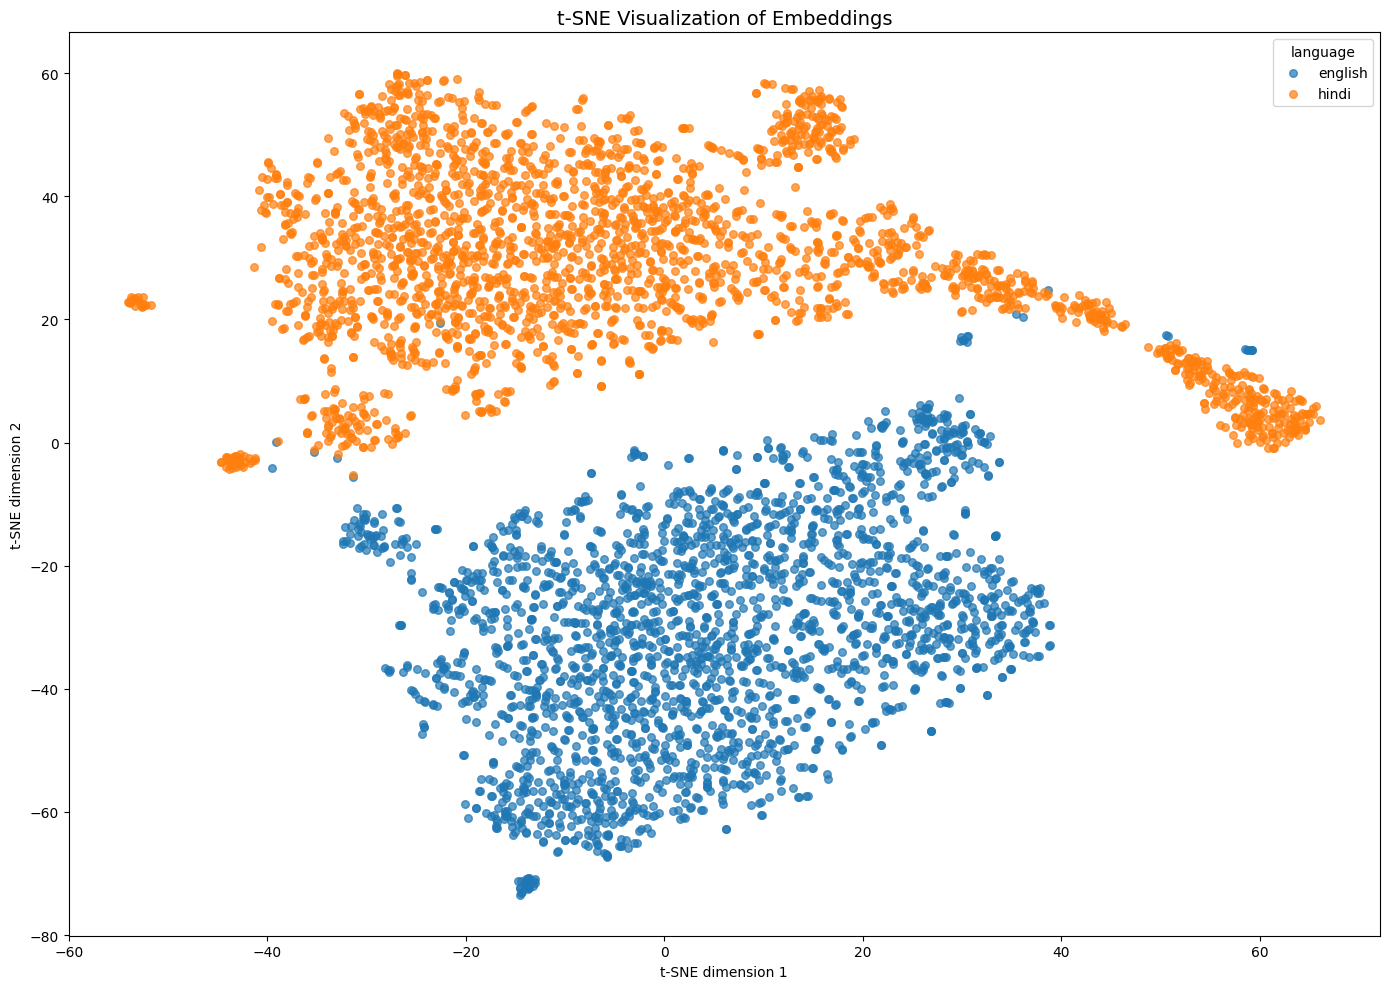

(array([[-14.567761 , -73.43774  ],
        [ -3.2349362, -51.9415   ],
        [  1.4705613, -22.363697 ],
        ...,
        [ 58.65608  ,  11.011622 ],
        [-34.378365 ,  23.047235 ],
        [-22.56355  ,  19.360792 ]], dtype=float32),
                                                sentence language
 0                              A black box in your car?  english
 1     As America's road planners struggle to find th...  english
 2     The devices, which track every mile a motorist...  english
 3     The usually dull arena of highway planning has...  english
 4     Libertarians have joined environmental groups ...  english
 ...                                                 ...      ...
 5009  इस शाही पार्टी के लिए 250 वीवीआईपी लोगों को भी...    hindi
 5010  इनमें जोधपुर राजपरिवार और उम्मैद भवन के मालिक ...    hindi
 5011  एल.एन.मित्तल, सचिन तेंदुलकर, फिल्म अभिनेता अनि...    hindi
 5012  मेहमानों को लाने-ले जाने के लिए 32 चार्टर्ड वि...    hindi
 5013  The devices, which tr

In [ ]:
vectors_path = '/content/combined_final_vectors.tsv'
metadata_path = '/content/combined_final_metadata.tsv'
visualize_embeddings(vectors_path, metadata_path, color_by='language', label_column='text')

# Part - 2 : Finetuning

## Loading libraries

In [ ]:
import random
import numpy as np
from tqdm import tqdm
from typing import List, Dict, Tuple

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from datasets import load_dataset
from transformers import AutoModel, AutoTokenizer

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")
dataset = load_dataset("cfilt/iitb-english-hindi")
print(dataset)

## Constructing balanced postive and negative pairs for a training and validation dataset

In [ ]:
class Balanced_Dataset(Dataset):
    def __init__(self, dataset, tokenizer, num_examples=10000, max_length=128):

        self.tokenizer = tokenizer
        self.max_length = max_length

        num_examples = num_examples if num_examples % 2 == 0 else num_examples + 1
        self.num_pairs = num_examples // 2  # Half positive, half negative

        self.all_pairs = self.create_dataset(dataset, self.num_pairs)

    def create_dataset(self, dataset, num_pairs) -> List[Dict]:

        pairs = []
        all_en = [item['translation']['en'] for item in dataset]
        all_hi = [item['translation']['hi'] for item in dataset]
        dataset_size = len(all_en)

        print("Loading Positive pairs")
        indices = random.sample(range(dataset_size), num_pairs)
        for idx in tqdm(indices):
            pairs.append({'en_text': all_en[idx],'hi_text': all_hi[idx],'label': 1})

        print("Loading negative pairs")
        for idx in tqdm(indices):
            neg_idx = idx
            while neg_idx == idx:
                neg_idx = random.randint(0, dataset_size - 1)

            pairs.append({'en_text': all_en[idx],'hi_text': all_hi[neg_idx],'label': 0})

        return pairs

    def __len__(self):
        return len(self.all_pairs)

    def __getitem__(self, idx):

        pair = self.all_pairs[idx]
        en_tokens = self.tokenizer(pair['en_text'],padding='max_length',truncation=True, max_length=self.max_length,return_tensors='pt')
        hi_tokens = self.tokenizer(pair['hi_text'], padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')

        return {
            'en_input_ids': en_tokens['input_ids'].squeeze(),
            'en_attention_mask': en_tokens['attention_mask'].squeeze(),
            'hi_input_ids': hi_tokens['input_ids'].squeeze(),
            'hi_attention_mask': hi_tokens['attention_mask'].squeeze(),
            'label': torch.tensor(pair['label'], dtype=torch.long)
        }

In [ ]:
def create_train_val_datasets(dataset, tokenizer, train_size=10000, val_size=1040, test_size = 5014, max_length=128):
    train_data = Balanced_Dataset(dataset['train'], tokenizer, num_examples=train_size, max_length=max_length)
    val_data = Balanced_Dataset(dataset['validation'], tokenizer, num_examples=val_size, max_length=max_length)
    test_data = Balanced_Dataset(dataset['test'], tokenizer, num_examples=test_size, max_length=max_length)
    return train_data, val_data, test_data

## Loading 100000 training examples, 1040 examples & 5014 examples. Each dataset has equal no. of postive & negative examples

In [ ]:
train_data, val_data, test_data = create_train_val_datasets(dataset, tokenizer, train_size=100000)

Loading Positive pairs


100%|██████████| 50000/50000 [00:00<00:00, 211464.86it/s]


Loading negative pairs


100%|██████████| 50000/50000 [00:00<00:00, 665224.02it/s]


Loading Positive pairs


100%|██████████| 520/520 [00:00<00:00, 567092.58it/s]


Loading negative pairs


100%|██████████| 520/520 [00:00<00:00, 338197.87it/s]


Loading Positive pairs


100%|██████████| 2507/2507 [00:00<00:00, 677651.62it/s]


Loading negative pairs


100%|██████████| 2507/2507 [00:00<00:00, 631842.33it/s]


## Data Loading

In [ ]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)

In [ ]:
batch = next(iter(train_loader))
for k, v in batch.items():
    print(f"{k}: {v.shape}")

en_input_ids: torch.Size([32, 128])
en_attention_mask: torch.Size([32, 128])
hi_input_ids: torch.Size([32, 128])
hi_attention_mask: torch.Size([32, 128])
label: torch.Size([32])


## This model involves fine-tuning BERT with an additional classifier layer \( W \) on top:

$$
o = \text{softmax}(W^T (u, v, |u - v|))
$$

where \( u \) represents the English sentence embeddings and \( v \) represents the Hindi sentence embeddings.


In [ ]:
class CrosslingualBERT(nn.Module):
    def __init__(self, model_name="bert-base-multilingual-cased", num_labels=2):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        hidden_size = self.bert.config.hidden_size

        self.classifier = nn.Linear(3 * hidden_size, num_labels)

    def forward(self, en_input_ids, en_attention_mask, hi_input_ids, hi_attention_mask):
        en_outputs = self.bert(input_ids=en_input_ids, attention_mask=en_attention_mask, return_dict=True)
        u = self.mean_pooling(en_outputs.last_hidden_state, en_attention_mask)

        hi_outputs = self.bert(input_ids=hi_input_ids, attention_mask=hi_attention_mask, return_dict=True)
        v = self.mean_pooling(hi_outputs.last_hidden_state, hi_attention_mask)

        abs_diff = torch.abs(u - v)
        combined = torch.cat([u, v, abs_diff], dim=1)
        logits = self.classifier(combined)

        return logits

    @staticmethod
    def mean_pooling(token_embeddings, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device):

    model.train()

    total_loss = 0
    correct_pred, total_pred  = 0, 0
    progress_bar = tqdm(dataloader, desc='Training')

    for batch in progress_bar:

        en_input_ids = batch['en_input_ids'].to(device)
        en_attention_mask = batch['en_attention_mask'].to(device)
        hi_input_ids = batch['hi_input_ids'].to(device)
        hi_attention_mask = batch['hi_attention_mask'].to(device)
        labels = batch['label'].to(device)

        logits = model(en_input_ids=en_input_ids, en_attention_mask=en_attention_mask, hi_input_ids=hi_input_ids, hi_attention_mask=hi_attention_mask)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predictions = torch.argmax(logits, dim=1)
        correct_pred += (predictions == labels).sum().item()
        total_pred += labels.size(0)

        total_loss += loss.item()
        current_acc = correct_pred / total_pred

        progress_bar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{current_acc:.4f}'})

    avg_loss = total_loss / len(dataloader)
    accuracy = correct_pred / total_pred
    return avg_loss, accuracy

In [ ]:
def evaluate(model, dataloader, criterion, device):
    model.eval()

    total_loss = 0
    correct_pred, total_pred = 0, 0
    all_pred, all_label = [], []

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc='Evaluating')
        for batch in progress_bar:

            en_input_ids = batch['en_input_ids'].to(device)
            en_attention_mask = batch['en_attention_mask'].to(device)
            hi_input_ids = batch['hi_input_ids'].to(device)
            hi_attention_mask = batch['hi_attention_mask'].to(device)
            labels = batch['label'].to(device)

            logits = model(en_input_ids=en_input_ids, en_attention_mask=en_attention_mask, hi_input_ids=hi_input_ids,hi_attention_mask=hi_attention_mask)

            loss = criterion(logits, labels)
            predictions = torch.argmax(logits, dim=1)

            correct_pred += (predictions == labels).sum().item()
            total_pred += labels.size(0)
            total_loss += loss.item()

            all_pred.extend(predictions.cpu().numpy())
            all_label.extend(labels.cpu().numpy())

            current_acc = correct_pred / total_pred
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{current_acc:.4f}'})

    avg_loss = total_loss / len(dataloader)
    accuracy = correct_pred / total_pred

    all_pred = np.array(all_pred)
    all_label = np.array(all_label)

    metrics = {'loss': avg_loss, 'accuracy': accuracy, 'positive_accuracy': np.mean(all_pred[all_label == 1] == 1),'negative_accuracy': np.mean(all_pred[all_label == 0] == 0)}
    return metrics

## Training was conducted for 3 epochs, but could not be fully complete due to GPU constraints.

In [ ]:
num_epochs = 3
criterion = nn.CrossEntropyLoss()
model = CrosslingualBERT().to(device)
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
best_val_acc = 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    train_loss, train_acc = train_epoch(model=model, dataloader=train_loader, criterion=criterion, optimizer=optimizer, device=device)
    print(f"Training Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f}")

    val_metrics = evaluate(model=model, dataloader=val_loader, criterion=criterion, device=device)
    print(f"Validation Metrics:")
    print(f"Loss: {val_metrics['loss']:.4f}")
    print(f"Accuracy: {val_metrics['accuracy']:.4f}")
    print(f"Positive Pair Accuracy: {val_metrics['positive_accuracy']:.4f}")
    print(f"Negative Pair Accuracy: {val_metrics['negative_accuracy']:.4f}")

    if val_metrics['accuracy'] > best_val_acc:
        best_val_acc = val_metrics['accuracy']
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_metrics': val_metrics,
        }, 'best_bilingual_bert_classifier.pt')
        print(f"Saved new best model with validation accuracy: {best_val_acc:.4f}")


Epoch 1/3


Training: 100%|██████████| 3125/3125 [1:05:02<00:00,  1.25s/it, loss=0.1619, acc=0.9089]


Training Loss: 0.2290, Accuracy: 0.9089


Evaluating: 100%|██████████| 33/33 [00:13<00:00,  2.37it/s, loss=0.4091, acc=0.9115]


Validation Metrics:
Loss: 0.1985
Accuracy: 0.9115
Positive Pair Accuracy: 0.9846
Negative Pair Accuracy: 0.8385
Saved new best model with validation accuracy: 0.9115

Epoch 2/3


Training: 100%|██████████| 3125/3125 [1:05:01<00:00,  1.25s/it, loss=0.0600, acc=0.9509]


Training Loss: 0.1327, Accuracy: 0.9509


Evaluating: 100%|██████████| 33/33 [00:14<00:00,  2.35it/s, loss=0.3644, acc=0.9202]


Validation Metrics:
Loss: 0.1906
Accuracy: 0.9202
Positive Pair Accuracy: 0.9654
Negative Pair Accuracy: 0.8750
Saved new best model with validation accuracy: 0.9202

Epoch 3/3


Training:  84%|████████▎ | 2612/3125 [54:26<10:38,  1.25s/it, loss=0.1556, acc=0.9695]

## Find Cosine Similarity, Accuracy & MRR

In [ ]:
def separate_sentences(dataset):
    english_sentences = []
    hindi_sentences = []

    for translation in dataset['translation']:
        english_sentences.append(translation['en'])
        hindi_sentences.append(translation['hi'])

    return english_sentences, hindi_sentences

english_sentences, hindi_sentences = separate_sentences(dataset['test'])

In [ ]:
def get_sentence_embeddings(model, tokenizer, sentences, device='cuda'):
    model.to(device)
    embeddings = []
    model.eval()

    with torch.no_grad():
        for sentence in tqdm(sentences):
            inputs = tokenizer(sentence, padding=True, truncation=True, max_length=512, return_tensors='pt').to(device)
            outputs = model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :]
            embeddings.append(cls_embedding.cpu().numpy()[0])

    return np.array(embeddings)

In [ ]:
def compute_alignment_metrics(en_embeddings, hi_embeddings):

    similarities = np.array([
        cosine_similarity(en_emb.reshape(1, -1), hi_emb.reshape(1, -1))[0][0]
        for en_emb, hi_emb in zip(en_embeddings, hi_embeddings)
    ])

    mean_similarity = np.mean(similarities)

    n = len(en_embeddings)
    similarity_matrix = cosine_similarity(en_embeddings, hi_embeddings)
    correct_retrievals = sum(np.argmax(similarity_matrix, axis=1) == np.arange(n))
    retrieval_accuracy = correct_retrievals / n

    ranks = []
    for i in range(n):
        sorted_indices = np.argsort(-similarity_matrix[i])
        rank = np.where(sorted_indices == i)[0][0] + 1
        ranks.append(1/rank)
    mrr = np.mean(ranks)

    return {
        'mean_similarity': mean_similarity,
        'retrieval_accuracy': retrieval_accuracy,
        'similarities': similarities,
        'mean_reciprocal_rank': mrr
    }

In [ ]:
n_sentences = 10000
english_sentences = english_sentences[:n_sentences]
hindi_sentences = hindi_sentences[:n_sentences]
new_model = model.bert
en_embeddings = get_sentence_embeddings(new_model, tokenizer, english_sentences, device)
hi_embeddings = get_sentence_embeddings(new_model, tokenizer, hindi_sentences, device)

100%|██████████| 2507/2507 [00:24<00:00, 103.53it/s]


In [ ]:
metrics = compute_alignment_metrics(en_embeddings, hi_embeddings)

print("Baseline Analysis Results:")

print(f"\nMean Cosine Similarity: {metrics['mean_similarity']:.4f}")
print(f"Retrieval Accuracy: {metrics['retrieval_accuracy']:.4f}")
print(f"Mean Reciprocal Rank: {metrics['mean_reciprocal_rank']:.4f}")

Baseline Analysis Results:

Mean Cosine Similarity: 0.8977
Retrieval Accuracy: 0.4164
Mean Reciprocal Rank: 0.5202


## Saving the embeddings and sentences i.e meta data for test dataset after training

In [ ]:
def save_embeddings_and_sentences(model, dataloader, device, max_elements=None):

    en_embeddings, hi_embeddings = [],[]
    en_sentences, hi_sentences = [], []
    labels = []

    total_elements = 0
    model.eval()
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting embeddings"):
            en_outputs = model.bert(input_ids=batch['en_input_ids'].to(device), attention_mask=batch['en_attention_mask'].to(device), return_dict=True)
            en_emb = model.mean_pooling(en_outputs.last_hidden_state, batch['en_attention_mask'].to(device))

            hi_outputs = model.bert(input_ids=batch['hi_input_ids'].to(device), attention_mask=batch['hi_attention_mask'].to(device),return_dict=True)
            hi_emb = model.mean_pooling(hi_outputs.last_hidden_state, batch['hi_attention_mask'].to(device))

            en_embeddings.append(en_emb.cpu().numpy())
            hi_embeddings.append(hi_emb.cpu().numpy())
            labels.append(batch['label'].numpy())

            en_sents = tokenizer.batch_decode(batch['en_input_ids'], skip_special_tokens=True)
            hi_sents = tokenizer.batch_decode(batch['hi_input_ids'], skip_special_tokens=True)
            en_sentences.extend(en_sents)
            hi_sentences.extend(hi_sents)

            total_elements += batch['en_input_ids'].size(0)
            if max_elements and total_elements >= max_elements:
                break

    en_embeddings = np.vstack(en_embeddings)
    hi_embeddings = np.vstack(hi_embeddings)
    labels = np.concatenate(labels)

    if max_elements:
        en_embeddings = en_embeddings[:max_elements]
        hi_embeddings = hi_embeddings[:max_elements]
        labels = labels[:max_elements]
        en_sentences = en_sentences[:max_elements]
        hi_sentences = hi_sentences[:max_elements]

    np.save('en_ft_embeddings.npy', en_embeddings)
    np.save('hi_ft_embeddings.npy', hi_embeddings)
    np.save('labels.npy', labels)
    np.save('en_ft_sentences.npy', np.array(en_sentences))
    np.save('hi_ft_sentences.npy', np.array(hi_sentences))

print("\nSaving validation data embeddings...")
save_embeddings_and_sentences(model, test_loader, device)



Saving validation data embeddings...



Extracting embeddings: 100%|██████████| 157/157 [01:04<00:00,  2.42it/s]


## Convert the embeddings into tsv file


In [ ]:
en_embeddings = np.load("/content/en_ft_embeddings.npy")
english_sentences = np.load("/content/en_ft_sentences.npy")
hi_embeddings = np.load("/content/hi_ft_embeddings.npy")
hindi_sentences = np.load("/content/hi_ft_sentences.npy")

In [ ]:
len(hi_embeddings), len(hindi_sentences)

(5014, 5014)

In [ ]:
combined_embeddings = np.vstack([en_embeddings, hi_embeddings])
combined_sentences, language_labels = [], []

for sentence in english_sentences:
    combined_sentences.append(sentence)
    language_labels.append("english")

for sentence in hindi_sentences:
    combined_sentences.append(sentence)
    language_labels.append("hindi")

In [ ]:
with open("combined_final_ft_vectors.tsv", 'w', encoding='utf-8') as f:
    for embedding in combined_embeddings:
        f.write('\t'.join([str(value) for value in embedding]) + '\n')

with open("combined_final_ft_metadata.tsv", 'w', encoding='utf-8') as f:
    f.write("sentence\tlanguage\n")
    for i in range(len(combined_sentences)):
        clean_sentence = str(combined_sentences[i]).replace('\t', ' ').replace('\n', ' ')
        f.write(f"{clean_sentence}\t{language_labels[i]}\n")

In [ ]:
combined_embeddings.shape, len(combined_sentences)

((10028, 768), 10028)

## Plotting the embeddings using t-SNE (Referred others code for this)

In [ ]:
def load_embeddings_and_metadata(vectors_path, metadata_path=None):

    print(f"Loading embeddings from: {vectors_path}")
    try:
        embeddings = pd.read_csv(vectors_path, sep='\t', header=None)
    except:
        embeddings = pd.read_csv(vectors_path, sep=',', header=None)

    print(f"Loaded embeddings with shape: {embeddings.shape}")

    metadata = None
    if metadata_path:
        print(f"Loading metadata from: {metadata_path}")
        try:
            # Try tab as delimiter first
            metadata = pd.read_csv(metadata_path, sep='\t')
            row_df = metadata.iloc[[2]].copy()  # Copy the specific row
            row_df = pd.concat([row_df] * 25, ignore_index=True)  # Duplicate it 25 times
            metadata = pd.concat([metadata, row_df], ignore_index=True)  # Append to metadata

        except:
            # If that fails, try comma delimiter
            metadata = pd.read_csv(metadata_path, sep=',')

        print(f"Loaded metadata with shape: {metadata.shape}")

        # Check that metadata and embeddings have matching row counts
        if len(metadata) != len(embeddings):
            print(f"Warning: Metadata ({len(metadata)} rows) and embeddings ({len(embeddings)} rows) have different lengths")

    return embeddings.values, metadata

# Run t-SNE
def run_tsne(embeddings, perplexity=30, n_components=2, learning_rate='auto', n_iter=1000):
    print(f"Running t-SNE with {embeddings.shape[1]} dimensions → {n_components} dimensions...")
    print(f"Parameters: perplexity={perplexity}, n_iter={n_iter}")

    start_time = time.time()

    tsne = TSNE(
        n_components=n_components,
        perplexity=perplexity,
        learning_rate=learning_rate,
        n_iter=n_iter,
        init='pca',
        random_state=42,
        verbose=1
    )

    tsne_result = tsne.fit_transform(embeddings)

    elapsed_time = time.time() - start_time
    print(f"t-SNE completed in {elapsed_time:.2f} seconds")

    return tsne_result

# Plot the t-SNE projections
def plot_tsne(tsne_result, metadata=None, color_by=None, figsize=(12, 10), title=None):
    plt.figure(figsize=figsize)

    # Check if we're plotting 2D or 3D
    is_3d = (tsne_result.shape[1] == 3)

    if is_3d:
        ax = plt.axes(projection='3d')
    else:
        ax = plt.axes()

    # If metadata and color_by are provided, use them to color points
    if metadata is not None and color_by is not None and color_by in metadata.columns:
        color_values = metadata[color_by]

        # Check if the color values are categorical or numerical
        if pd.api.types.is_numeric_dtype(color_values):
            # Numerical values - use a colormap
            if is_3d:
                scatter = ax.scatter(
                    tsne_result[:, 0], tsne_result[:, 1], tsne_result[:, 2],
                    c=color_values, cmap='viridis',
                    alpha=0.7, s=30
                )
            else:
                scatter = ax.scatter(
                    tsne_result[:, 0], tsne_result[:, 1],
                    c=color_values, cmap='viridis',
                    alpha=0.7, s=30
                )
            plt.colorbar(scatter, label=color_by)
        else:
            # Categorical values - use distinct colors
            categories = color_values.unique()

            # Create a dictionary to map categories to colors
            colors = plt.cm.tab10(np.linspace(0, 1, len(categories)))
            color_dict = {cat: colors[i] for i, cat in enumerate(categories)}

            # Plot each category with a different color
            for cat in categories:
                mask = color_values == cat
                if is_3d:
                    ax.scatter(
                        tsne_result[mask, 0], tsne_result[mask, 1], tsne_result[mask, 2],
                        label=cat, alpha=0.7, s=30
                    )
                else:
                    ax.scatter(
                        tsne_result[mask, 0], tsne_result[mask, 1],
                        label=cat, alpha=0.7, s=30
                    )

            plt.legend(title=color_by)
    else:
        # Simple plot without coloring
        if is_3d:
            ax.scatter(
                tsne_result[:, 0], tsne_result[:, 1], tsne_result[:, 2],
                alpha=0.7, s=30
            )
        else:
            ax.scatter(
                tsne_result[:, 0], tsne_result[:, 1],
                alpha=0.7, s=30
            )

    # Set labels and title
    if is_3d:
        ax.set_xlabel('t-SNE dimension 1')
        ax.set_ylabel('t-SNE dimension 2')
        ax.set_zlabel('t-SNE dimension 3')
    else:
        ax.set_xlabel('t-SNE dimension 1')
        ax.set_ylabel('t-SNE dimension 2')

    if title:
        plt.title(title, fontsize=14)
    else:
        plt.title('t-SNE Visualization of Embeddings', fontsize=14)

    plt.tight_layout()
    plt.show()

# Label some points in the t-SNE plot
def plot_tsne_with_labels(tsne_result, metadata, label_column, n_labels=50, figsize=(14, 10), color_by=None):
    # First create the basic plot
    plot_tsne(tsne_result, metadata, color_by, figsize)

    # Make sure we have valid label data
    if label_column not in metadata.columns:
        print(f"Warning: Label column '{label_column}' not found in metadata")
        return

    # Select a subset of points to label
    np.random.seed(42)
    indices = np.random.choice(len(tsne_result), size=min(n_labels, len(tsne_result)), replace=False)

    # Check if we're plotting 2D or 3D
    is_3d = (tsne_result.shape[1] == 3)

    for idx in indices:
        label = str(metadata[label_column].iloc[idx])

        if is_3d:
            ax = plt.gca(projection='3d')
            ax.text(
                tsne_result[idx, 0], tsne_result[idx, 1], tsne_result[idx, 2],
                label, fontsize=9, alpha=0.8
            )
        else:
            plt.annotate(
                label,
                (tsne_result[idx, 0], tsne_result[idx, 1]),
                fontsize=9, alpha=0.8
            )

    plt.tight_layout()
    plt.show()

def visualize_embeddings(vectors_path, metadata_path=None, perplexity=30, n_components=2,
                         n_iter=1000, color_by=None, label_column=None, n_labels=50):

    embeddings, metadata = load_embeddings_and_metadata(vectors_path, metadata_path)
    tsne_result = run_tsne(embeddings, perplexity, n_components, n_iter=n_iter)

    # Visualize
    if label_column and metadata is not None:
        plot_tsne_with_labels(tsne_result, metadata, label_column, n_labels, color_by=color_by)
    else:
        plot_tsne(tsne_result, metadata, color_by)

    return tsne_result, metadata

Loading embeddings from: /content/drive/MyDrive/combined_final_ft_vectors.tsv
Loaded embeddings with shape: (10028, 768)
Loading metadata from: /content/drive/MyDrive/combined_final_ft_metadata.tsv
Loaded metadata with shape: (10028, 2)
Running t-SNE with 768 dimensions → 2 dimensions...
Parameters: perplexity=30, n_iter=1000
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10028 samples in 0.068s...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 10028 samples in 6.424s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10028
[t-SNE] Computed conditional probabilities for sample 2000 / 10028
[t-SNE] Computed conditional probabilities for sample 3000 / 10028
[t-SNE] Computed conditional probabilities for sample 4000 / 10028
[t-SNE] Computed conditional probabilities for sample 5000 / 10028
[t-SNE] Computed conditional probabilities for sample 6000 / 10028
[t-SNE] Computed conditional probabilities for sample 7000 / 10028
[t-SNE] Computed conditional probabilities for sample 8000 / 10028
[t-SNE] Computed conditional probabilities for sample 9000 / 10028
[t-SNE] Computed conditional probabilities for sample 10000 / 10028
[t-SNE] Computed conditional probabilities for sample 10028 / 10028
[t-SNE] Mean sigma: 4.030773
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.986359
[t-SNE] KL divergence after 1000 iterations: 1.474502
t-SNE completed in 98.11 seconds


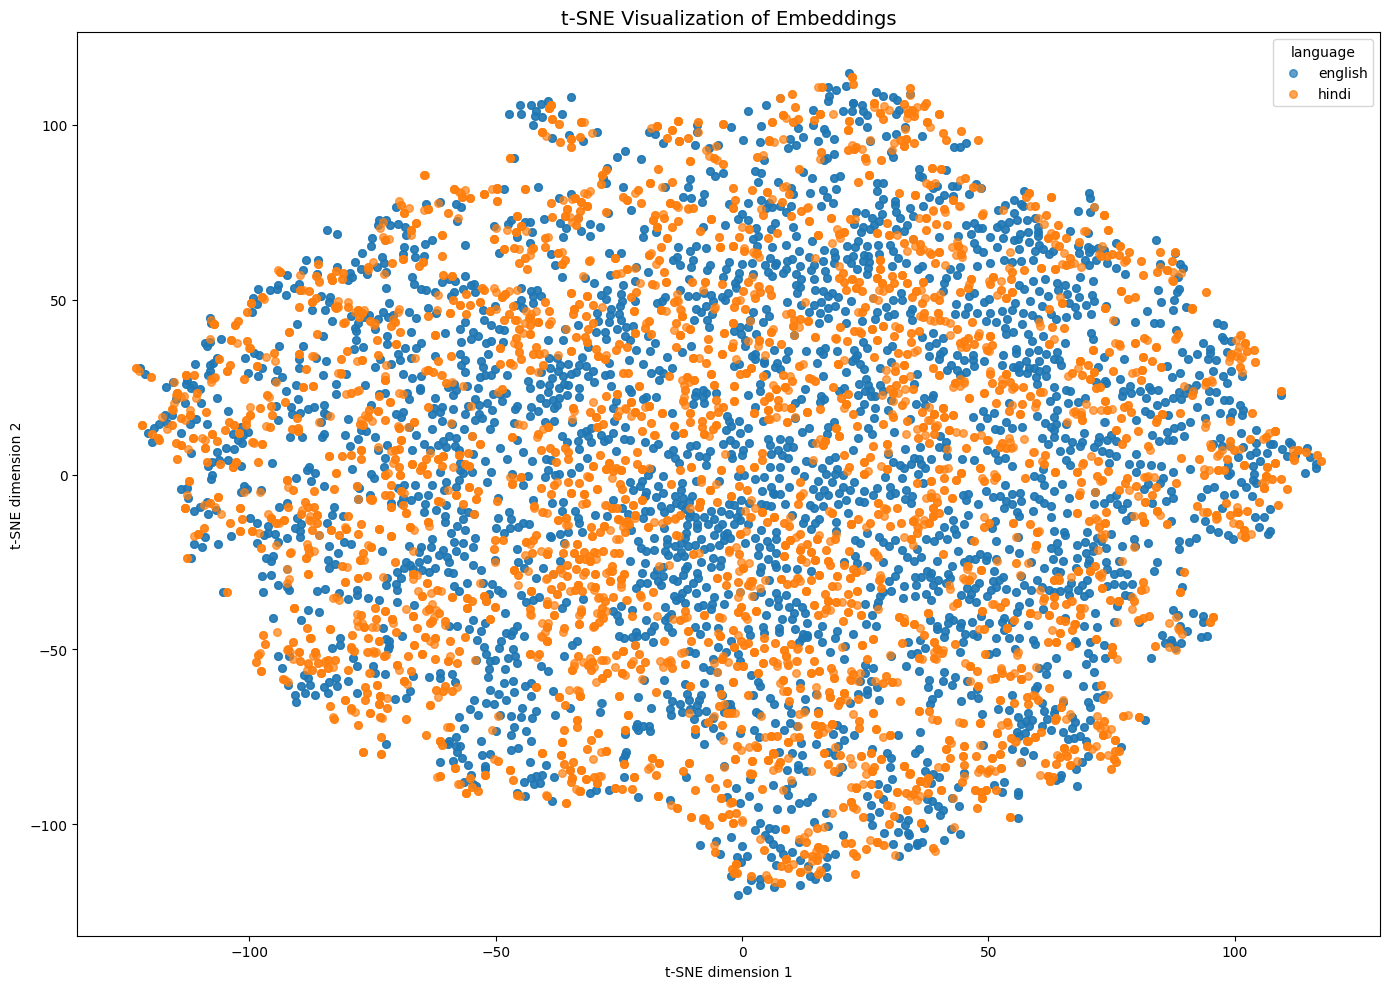

(array([[-50.699135,  18.417467],
        [ 88.950584, -27.679895],
        [ 45.73465 , -32.39144 ],
        ...,
        [-49.65371 ,  82.05149 ],
        [-92.31829 , -26.987038],
        [ 26.628262,  50.463123]], dtype=float32),
                                                 sentence language
 0      Scientists have shed more light on how the mov...  english
 1      The third son of Hirachand Govaradhandas Amban...  english
 2      On Wednesday he was returning home on his bicy...  english
 3      According to The Star newspaper, the new bill ...  english
 4      Among the officials of the executive committee...  english
 ...                                                  ...      ...
 10023  On Wednesday he was returning home on his bicy...  english
 10024  On Wednesday he was returning home on his bicy...  english
 10025  On Wednesday he was returning home on his bicy...  english
 10026  On Wednesday he was returning home on his bicy...  english
 10027  On Wednesday he was r

In [ ]:
vectors_path = '/content/drive/MyDrive/combined_final_ft_vectors.tsv'
metadata_path = '/content/drive/MyDrive/combined_final_ft_metadata.tsv'
visualize_embeddings(vectors_path, metadata_path, color_by='language', label_column='text')